Project Code

In [1]:
# Task 0: Importing relevant libraries

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random
from scipy.stats.qmc import LatinHypercube
from scipy import stats
from scipy.stats import norm

In [2]:
# Task 1: Defining an open maze

"""
Input:
1. Size of Maze (int)
2. Number of coins (int)
3. Number of enemies (int)

Output:
1. Maze (2D NumPy array)
2. Position of coins (list of tuples)
3. Position of enemies (list of tuples)
"""

def wall_creation(maze, wall_density=0.1):
  num_walls = int(wall_density * maze.size * maze.size)
  wall_positions = np.random.choice(maze.size * maze.size, num_walls)
  wall_coordinates = np.unravel_index(wall_positions, (maze.size, maze.size))
  wall_coordinates = list(zip(*wall_coordinates))
  wall_coordinates = remove_walls_at_assets(maze, wall_coordinates)
  return wall_coordinates

def remove_walls_at_assets(maze, wall_coordinates):
  maze_edges = [(i, 0) for i in range(maze.size)]
  maze_edges += [(i, maze.size-1) for i in range(maze.size)]
  maze_edges += [(0, j) for j in range(maze.size)]
  maze_edges += [(maze.size-1, j) for j in range(maze.size)]

  wall_coordinates = [w for w in wall_coordinates if w not in maze.coin_pos]
  wall_coordinates = [w for w in wall_coordinates if w not in maze.enemy_pos]
  wall_coordinates = [w for w in wall_coordinates if w not in maze_edges]

  game_assets = maze.coin_pos + maze.enemy_pos
  for g in game_assets:
    i, j = g[0], g[1]
    neighbours =[(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
    if neighbours in wall_coordinates:
      wall_coordinates.remove(random.choice(neighbours))

  return wall_coordinates

class Maze:

    def __init__(self, size_of_maze, wall_density, nr_of_coins, nr_of_enemies, sampling):
        self.size = size_of_maze
        self.wall_density = wall_density
        self.nr_of_coins = nr_of_coins
        self.nr_of_enemies = nr_of_enemies
        self.sampling = sampling

        self.maze = np.zeros((self.size, self.size), dtype=int)

        if self.sampling == 'Random':
          self.coin_pos = [divmod(ele, self.size - 1) for ele in random.sample(range(1, (self.size - 1) * (self.size - 1)), self.nr_of_coins)]
          self.enemy_pos = [divmod(ele, self.size - 1) for ele in random.sample(range(1, (self.size - 1) * (self.size - 1)), self.nr_of_enemies)]

        elif self.sampling == 'LHS':
          self.sampler = LatinHypercube(d=2)
          self.sample_coins = self.sampler.integers(l_bounds = 1,u_bounds = self.size - 1, n = self.nr_of_coins)
          self.sample_enemies = self.sampler.integers(l_bounds = 1,u_bounds = self.size - 1, n = self.nr_of_enemies)
          self.coin_pos = [tuple(ele) for ele in self.sample_coins]
          self.enemy_pos = [tuple(ele) for ele in self.sample_enemies]

        self.wall_pos = wall_creation(self, self.wall_density)

In [3]:
# Task 2: A-star pathfinding algorithm

"""
Input:
1. Maze instance (class object)
2. Start node (tuple)
3. End node (tuple)
4. Avoided nodes (list of tuples)

Output:
1. Path (list of tuples)
"""

class Node:
    def __init__(self, position, parent=None):
        self.position = position
        self.parent = parent
        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def astar(maze, start, end, avoided_nodes):
    rows, cols = len(maze), len(maze[0])

    start_node = Node(start)
    start_node.g = start_node.h = start_node.f = 0

    end_node = Node(end)

    open_list = [start_node]
    closed_set = set()

    while open_list:
        current_node = min(open_list, key=lambda node: node.f)
        open_list.remove(current_node)
        closed_set.add(current_node.position)

        if current_node == end_node:
            path = []
            while current_node is not None:
                path.append(current_node.position)
                current_node = current_node.parent
            return path[::-1]

        neighbours = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        for neighbour in neighbours:
            neighbour_pos = (current_node.position[0] + neighbour[0], current_node.position[1] + neighbour[1])

            if neighbour_pos[0] < 0 or neighbour_pos[0] >= rows or neighbour_pos[1] < 0 or neighbour_pos[1] >= cols:
                continue

            if maze[neighbour_pos[0]][neighbour_pos[1]] == 1 or neighbour_pos in avoided_nodes:
                continue

            neighbour_node = Node(neighbour_pos, parent=current_node)
            neighbour_node.g = current_node.g + 1
            neighbour_node.h = heuristic(neighbour_pos, end)
            neighbour_node.f = neighbour_node.g + neighbour_node.h

            if neighbour_pos in closed_set:
                continue

            existing_node = next((node for node in open_list if node == neighbour_node), None)
            if existing_node and neighbour_node.g >= existing_node.g:
                continue

            open_list.append(neighbour_node)

    return None


In [4]:
# Task 3: Player profiling and path traversal

"""
Input:
1. Instance of the maze class
2. Player type: Neutral, Greedy, Aggressive

Output:
1. Path, in the form of list of tuples for all the nodes the player has traversed
2. Coins collected after path traversal and reaching the end node
3. Enemies defeated after path traversal and reaching the end node
4. Steps taken from start node to end node
"""

def Player(maze, player_type):

    # Task 3a: Initialising maze parameters
    m = maze
    current_pos = (0, 0)
    end_pos = (m.size - 1, m.size - 1)
    coin_pos = m.coin_pos
    enemy_pos = m.enemy_pos
    wall_pos = m.wall_pos
    #print(len(coin_pos), len(enemy_pos))
    test = 'F'
    for i in range(len(coin_pos)):
        if coin_pos[i] in enemy_pos:
            test = 'T'
    #print(test)

    # Task 3b: Initialising game asset parameters
    path = []
    preferred_nodes = []
    coins_list = []
    enemies_list = []
    steps_taken = 0

    avoided_nodes = wall_pos
    if player_type == 'Neutral':
        preferred_nodes = sorted(coin_pos + enemy_pos) + [end_pos]
    elif player_type == 'Greedy':
            #for enemy in enemy_pos:
                #if enemy not in coin_pos:
                    #avoided_nodes.append(enemy)
        preferred_nodes = sorted(coin_pos) + [end_pos]
    elif player_type == 'Aggressive':
            #for coin in coin_pos:
                #if coin not in enemy_pos:
                    #avoided_nodes.append(coin)
        preferred_nodes = sorted(enemy_pos) + [end_pos]

    for node in preferred_nodes:
      path += astar(m.maze, current_pos, node, avoided_nodes)
      current_pos = path[-1]
      path = path[:-1]
    path += [end_pos]

    for p in path:
      if p in coin_pos:
        coins_list += [p]
      elif p in enemy_pos:
        enemies_list += [p]

    coins_collected = len(list(set(coins_list)))
    enemies_defeated = len(list(set(enemies_list)))
    steps_taken = len(path) - 1

    #print('Path:', path)
    return path, coins_collected, enemies_defeated, steps_taken

In [5]:
# Task 4: Visualise the maze with all game assets

"""
Input:
1. Maze instance, m (Class object)
2. Coins collected by the player (int)
3. Enemies defeated by the player (int)
4. Steps taken by the player (int)
5. Path traversed by the player (list of tuples)
6. Player type/profile (string - 'Greedy', 'Neutral', 'Aggressive)

Output:
1. Displays two plots - (left) maze with game assets
                        (right) maze with path traversed
2. Additional information displayed in the bottom - player profile, coins collected, enemies defeated, steps taken.
"""

def visualise_maze(m, coins_collected, enemies_defeated, steps_taken, path, player_type):

    for posn in m.coin_pos:
        if posn in m.enemy_pos:
            i, j = posn[0], posn[1]
            m.maze[i][j] = 4

    for posn in m.wall_pos:
        i, j = posn[0], posn[1]
        m.maze[i][j] = 1

    for coin in m.coin_pos:
        if coin not in m.enemy_pos:
            i, j = coin[0], coin[1]
            m.maze[i][j] = 2

    for enemy in m.enemy_pos:
        if enemy not in m.coin_pos:
            i, j = enemy[0], enemy[1]
            m.maze[i][j] = 3

    #print(m.maze)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.suptitle('Player style: {}\nCoins collected (shown in GOLD): {:d}\nEnemies defeated (shown in MAGENTA): {:d}\nSteps taken (shown in GRAY): {:d}'.format(player_type, coins_collected, enemies_defeated, steps_taken), y=0.25)
    ax0 = ax[0]
    ax1 = ax[1]

    if 4 in m.maze:
        cmap0 = colors.ListedColormap(['white', 'black', 'gold', 'magenta', 'darkturquoise'])
    else:
        cmap0 = colors.ListedColormap(['white', 'black', 'gold', 'magenta'])
    ax0.imshow(m.maze, cmap=cmap0)
    ax0.grid(which='both', axis='both', linestyle='-', color='k', linewidth=2)
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_title('Maze before path traversal')

    for p1 in path:
        i, j = p1[0], p1[1]
        m.maze[i][j] = 5

    cmap1 = colors.ListedColormap(['white', 'black', 'gold', 'magenta', 'darkturquoise', 'lightgray'])
    ax1.imshow(m.maze, cmap=cmap1)
    ax1.grid(which='both', axis='both', linestyle='-', color='k', linewidth=10)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('Maze after path traversal')

    plt.show()
    print('** \'Dark Turquoise\' represents locations where coins and enemies coincide **')
    print('Coins collected (shown in GOLD): {:d}'.format(coins_collected))
    print('Enemies defeated (shown in MAGENTA): {:d}'.format(enemies_defeated))
    print('Steps taken (shown in GRAY): {:d}\n'.format(steps_taken))

In [6]:
def iteration_greedy(num_simulations):
  size = 25
  nr_of_coins = 10
  nr_of_enemies = 10

  coin_data = []
  enemy_data = []
  step_data = []

  m = Maze(size, 0.01, nr_of_coins, nr_of_enemies, 'LHS')

  for iteration in range(num_simulations):
    path, coins_collected, enemies_defeated, steps_taken = Player(m, 'Greedy')
    coin_data.append(coins_collected)
    enemy_data.append(enemies_defeated)
    step_data.append(steps_taken)
  return np.mean(step_data), m.coin_pos, m.enemy_pos

step_data_greedy, coin, enemy = iteration_greedy(100)
print(step_data_greedy, coin, enemy)

126.0 [(11, 16), (23, 22), (5, 3), (9, 20), (19, 6), (4, 8), (16, 19), (20, 13), (14, 1), (3, 10)] [(20, 15), (15, 2), (18, 18), (22, 12), (7, 21), (11, 8), (12, 13), (9, 5), (2, 20), (3, 7)]


In [7]:
def iteration_aggressive(num_simulations):
  size = 25
  nr_of_coins = 10
  nr_of_enemies = 10

  coin_data = []
  enemy_data = []
  step_data = []

  m = Maze(size, 0.01, nr_of_coins, nr_of_enemies, 'LHS')

  for iteration in range(num_simulations):
    path, coins_collected, enemies_defeated, steps_taken = Player(m, 'Aggressive')
    coin_data.append(coins_collected)
    enemy_data.append(enemies_defeated)
    step_data.append(steps_taken)
  return np.mean(step_data), m.coin_pos, m.enemy_pos

step_data_aggressive, coin, enemy = iteration_aggressive(100)
print(step_data_aggressive, coin, enemy)

128.0 [(20, 22), (12, 11), (8, 18), (16, 15), (5, 1), (2, 8), (17, 5), (21, 7), (3, 19), (12, 12)] [(1, 10), (19, 6), (19, 15), (21, 10), (7, 22), (4, 20), (8, 2), (12, 18), (15, 3), (13, 14)]


In [8]:
def iteration_neutral(num_simulations):
  size = 25
  nr_of_coins = 10
  nr_of_enemies = 10

  coin_data = []
  enemy_data = []
  step_data = []

  m = Maze(size, 0.01, nr_of_coins, nr_of_enemies, 'LHS')

  for iteration in range(num_simulations):
    path, coins_collected, enemies_defeated, steps_taken = Player(m, 'Neutral')
    coin_data.append(coins_collected)
    enemy_data.append(enemies_defeated)
    step_data.append(steps_taken)
  return np.mean(step_data), m.coin_pos, m.enemy_pos

step_data_neutral, coin, enemy = iteration_neutral(100)
print(step_data_neutral, coin, enemy)

184.0 [(2, 5), (9, 21), (18, 19), (7, 13), (16, 1), (20, 16), (11, 22), (22, 9), (4, 12), (14, 6)] [(4, 5), (11, 12), (12, 2), (1, 23), (15, 7), (9, 19), (6, 9), (17, 17), (23, 11), (20, 15)]


In [9]:
# Task 5: Bayesian Optimisation
"""
Input:
1. Player style (string - 'Greedy', 'Neutral', 'Aggressive')

Output:
1. Samples containing path and steps taken - (list of float (steps taken) and tuples (path))
2. Optimal mean steps (list of float)
3. Optimal coin positions (list of int)
4. Optimal enemy positions (list of int)
"""

# Defining the objective function
def objective_function(player_style):
  if player_style == 'Greedy':
    step_data, coin_pos, enemy_pos = iteration_greedy(100)
    return step_data, coin_pos, enemy_pos
  elif player_style == 'Aggressive':
    step_data, coin_pos, enemy_pos = iteration_aggressive(20)
    return step_data, coin_pos, enemy_pos
  elif player_style == 'Neutral':
    step_data, coin_pos, enemy_pos = iteration_neutral(100)
    return step_data, coin_pos, enemy_pos

def implementing_BO(player_style):
  # Defining the search space
  size = 25
  nr_of_coins = 10
  search_space = [(x, y) for x in range(size) for y in range(size)]
  samples = []

  # Defining surrogate model (TPE)
  def tpe_surrogate(objective_function, search_space, num_samples=20):
    samples = []
    for _ in range(num_samples):
      step, coin, enemy = objective_function(player_style)
      samples.append([coin + enemy, step])
    return samples

  # Defining Expected Improvement (EI) acquisition function
  def expected_improvement(samples, best_value):
    x = [sample[0] for sample in samples]
    y = [sample[1] for sample in samples]
    mean = np.mean(y)
    std = np.std(y)
    # Calculating maximised EI
    improvement = np.maximum(best_value - y, 0)
    Z = improvement / (std + 1e-9)
    EI = (improvement * norm.cdf(Z)) + (std * norm.pdf(Z))
    return EI

  # Implementing BO
  num_iterations = 20
  best_asset_positions = None
  optimal_mean_steps = 0

  for _ in range(num_iterations):
    surrogate_samples = tpe_surrogate(objective_function, search_space)
    surrogate_samples.sort(key=lambda x: x[1])

    gamma_quantile_steps = surrogate_samples[num_iterations // 2][1]
    ei_values = expected_improvement(surrogate_samples, gamma_quantile_steps)

    next_sample_index = np.argmax(ei_values)
    next_sample = surrogate_samples[next_sample_index][0]

    # Evaluating the next sample
    next_sample_mean_steps, _, _ = objective_function(player_style)
    samples.append(next_sample_mean_steps)
    if next_sample_mean_steps > 0.95 * gamma_quantile_steps and next_sample_mean_steps < 1.05 * gamma_quantile_steps:
        optimal_mean_steps = next_sample_mean_steps
        best_asset_positions = next_sample

  # Print the results
  print("Optimal positions of assets:", best_asset_positions)
  print("Optimal mean steps:", optimal_mean_steps)

  return samples, optimal_mean_steps, best_asset_positions[:nr_of_coins], best_asset_positions[nr_of_coins:]


In [10]:
samples, step, coin, enemy = implementing_BO('Greedy')

Optimal positions of assets: [(3, 11), (15, 13), (3, 2), (23, 19), (13, 7), (10, 17), (20, 17), (7, 4), (9, 8), (17, 23), (20, 9), (8, 15), (13, 12), (23, 19), (19, 1), (6, 21), (12, 19), (3, 4), (14, 6), (3, 11)]
Optimal mean steps: 124.0


In [11]:
samples_neutral, step, coin, enemy = implementing_BO('Neutral')

Optimal positions of assets: [(12, 4), (16, 17), (5, 2), (19, 20), (3, 10), (22, 17), (8, 22), (20, 10), (12, 6), (7, 14), (6, 9), (1, 2), (12, 4), (14, 11), (22, 22), (10, 6), (4, 16), (17, 14), (20, 21), (9, 17)]
Optimal mean steps: 184.0


In [12]:
samples_aggressive, step, coin, enemy = implementing_BO('Aggressive')

Optimal positions of assets: [(8, 15), (16, 13), (6, 11), (20, 19), (10, 20), (22, 22), (2, 10), (18, 7), (13, 5), (5, 2), (1, 10), (23, 1), (16, 5), (9, 19), (7, 22), (4, 13), (12, 15), (10, 18), (20, 7), (18, 5)]
Optimal mean steps: 124.0


Data visualisations and Debugging code

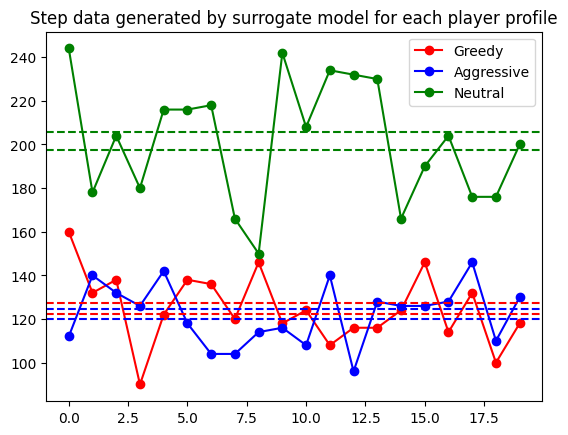

In [ ]:
plt.plot(samples[:20], marker='o', linestyle='-', color='r', label='Greedy')
plt.plot(samples_aggressive[:20], marker='o', linestyle='-', color='b', label='Aggressive')
plt.plot(samples_neutral[:20], marker='o', linestyle='-', color='g', label='Neutral')
plt.axhline(y=0.98*np.mean(samples), linestyle='--', color = 'r')
plt.axhline(y=1.02*np.mean(samples), linestyle='--', color = 'r')
plt.axhline(y=0.98*np.mean(samples_aggressive), linestyle='--', color = 'b')
plt.axhline(y=1.02*np.mean(samples_aggressive), linestyle='--', color = 'b')
plt.axhline(y=0.98*np.mean(samples_neutral), linestyle='--', color = 'g')
plt.axhline(y=1.02*np.mean(samples_neutral), linestyle='--', color = 'g')
plt.title('Step data generated by surrogate model for each player profile')
plt.legend()

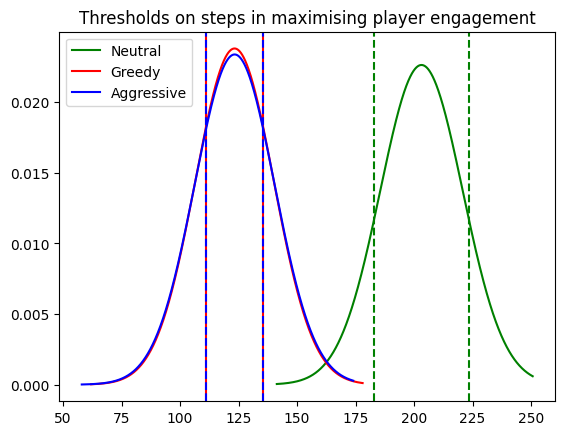

In [ ]:
y_neutral = stats.norm.pdf(x_neutral, np.mean(step_data_neutral), np.std(step_data_neutral))
plt.plot(x_neutral, y_neutral, color='green', label='Neutral')
plt.axvline(x=0.90*np.mean(step_data_neutral), linestyle='--', color='green')
plt.axvline(x=1.10*np.mean(step_data_neutral), linestyle='--', color='green')

y_greedy = stats.norm.pdf(x_greedy, np.mean(step_data_greedy), np.std(step_data_greedy))
plt.plot(x_greedy, y_greedy, color='red', label='Greedy')
plt.axvline(x=0.90*np.mean(step_data_greedy), linestyle='-', color='red')
plt.axvline(x=1.10*np.mean(step_data_greedy), linestyle='-', color='red')

y_aggressive = stats.norm.pdf(x_aggressive, np.mean(step_data_aggressive), np.std(step_data_aggressive))
plt.plot(x_aggressive, y_aggressive, color='blue', label='Aggressive')
plt.axvline(x=0.90*np.mean(step_data_aggressive), linestyle='--', color='blue')
plt.axvline(x=1.10*np.mean(step_data_aggressive), linestyle='--', color='blue')

plt.title('Thresholds on steps in maximising player engagement')
plt.legend()

In [ ]:
#x-axis ranges from -5 and 5 with .001 steps
x_greedy = np.arange(np.min(step_data_greedy), np.max(step_data_greedy), 0.001)
x_neutral = np.arange(np.min(step_data_neutral), np.max(step_data_neutral), 0.001)
x_aggressive = np.arange(np.min(step_data_aggressive), np.max(step_data_aggressive), 0.001)
y_greedy = stats.norm.pdf(x_greedy, np.mean(x_greedy), np.std(x_greedy))
y_aggressive = stats.norm.pdf(x_aggressive, np.mean(x_aggressive), np.std(x_aggressive))
y_neutral = stats.norm.pdf(x_neutral, np.mean(x_neutral), np.std(x_neutral))

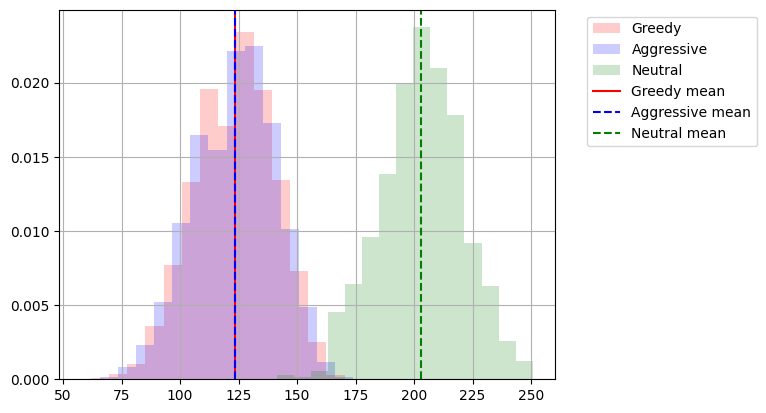

In [ ]:
from scipy.stats import norm
#bin_centres_greedy = 0.5 * (bin_greedy[1:] + bin_greedy[:-1])
#bin_centres_aggressive = 0.5 * (bin_aggressive[1:] + bin_aggressive[:-1])
#bin_centres_neutral = 0.5 * (bin_neutral[1:] + bin_neutral[:-1])

# Plot the histogram as line plots
fig, ax = plt.subplots(1,1)

#ax.plot(step_data_greedy, norm.pdf(step_data_greedy), 'r-', lw=5, alpha=1)
#ax.plot(step_data_aggressive, norm.pdf(step_data_aggressive), 'b-', lw=5, alpha=1)
#ax.plot(step_data_neutral, norm.pdf(step_data_neutral), 'g-', lw=5, alpha=1)
#r_greedy = norm.rvs(size=1000)
#r_aggressive = norm.rvs(size=1000)
#r_neutral = norm.rvs(size=1000)
ax.hist(step_data_greedy, density=True, bins=15, color='r', histtype='stepfilled', alpha=0.2, label='Greedy')
ax.hist(step_data_aggressive, density=True, bins=15, color='b', histtype='stepfilled', alpha=0.2, label='Aggressive')
ax.hist(step_data_neutral, density=True, bins=15, color='g', histtype='stepfilled', alpha=0.2, label='Neutral')
#plt.plot(bin_centres_neutral, hist_neutral, linestyle='-', color='green', label='Neutral')
ax.axvline(x=np.mean(step_data_greedy), linestyle='-', color='red', label='Greedy mean')
ax.axvline(x=np.mean(step_data_aggressive), linestyle='--', color='blue', label='Aggressive mean')
ax.axvline(x=np.mean(step_data_neutral), linestyle='--', color='green', label='Neutral mean')

#plt.xlabel('Number of Steps')
#plt.ylabel('Frequency')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
# Set the x-axis limits to cover the full range of bin centers
#plt.xlim(min(bin_centres_greedy), max(bin_centres_neutral))

# Set the y-axis limits to accommodate the data
#plt.ylim(0, max(max(hist_greedy), max(hist_aggressive), max(hist_neutral)) + 50)
plt.show()

In [ ]:
size = 20
nr_of_coins = 20
nr_of_enemies = 20

coin_data = []
enemy_data = []
step_data = []

for iteration in range(10):
    m = Maze(size, 0.1, nr_of_coins, nr_of_enemies, 'LHS')
    path, coins_collected, enemies_defeated, steps_taken = Player(m, 'Greedy')
    coin_data.append(coins_collected)
    enemy_data.append(enemies_defeated)
    step_data.append(steps_taken)

print(coin_data, '\n', enemy_data, '\n', step_data, '\n')

#visualise_maze(m, coins_collected, enemies_defeated, steps_taken, path)

[20, 20, 20, 19, 19, 20, 20, 20, 20, 20] 
 [4, 5, 3, 7, 6, 4, 3, 5, 5, 9] 
 [148, 162, 168, 150, 140, 170, 160, 172, 184, 156] 



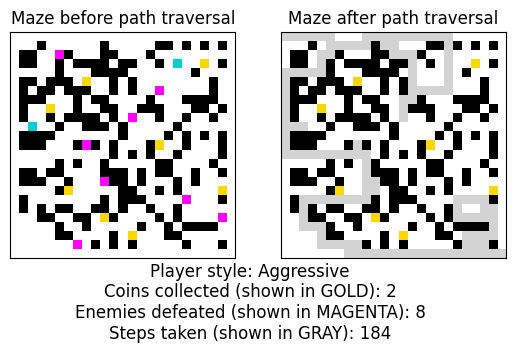

** 'Dark Turquoise' represents locations where coins and enemies coincide **
Coins collected (shown in GOLD): 2
Enemies defeated (shown in MAGENTA): 8
Steps taken (shown in GRAY): 184

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 5), (2, 5), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (1, 18), (2, 18), (3, 18), (4, 18), (5, 18), (6, 18), (6, 17), (6, 16), (6, 15), (6, 14), (7, 14), (7, 13), (8, 13), (9, 13), (8, 13), (7, 13), (7, 14), (6, 14), (5, 14), (4, 14), (3, 14), (2, 14), (2, 13), (2, 12), (1, 12), (1, 11), (0, 11), (0, 10), (0, 9), (1, 9), (1, 8), (1, 7), (1, 6), (1, 5), (2, 5), (2, 4), (3, 4), (4, 4), (4, 3), (4, 2), (4, 1), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (10, 1), (10, 2), (10, 1), (10, 0), (11, 0), (12, 0), (13, 0), (13, 1), (13, 2), (13, 3), (13, 4), (13, 5), (13, 6), (13, 7), (13, 8), (12, 8), (13, 8), (13, 9), (14, 9), (15, 9), (16, 9), (16, 10), (17, 10),

In [ ]:
size = 25
nr_of_coins = 10
nr_of_enemies = 10
wall_density = 0.4
m = Maze(size, wall_density, nr_of_coins, nr_of_enemies, 'LHS')
path, coins_collected, enemies_defeated, steps_taken = Player(m, 'Aggressive')
visualise_maze(m, coins_collected, enemies_defeated, steps_taken, path, 'Aggressive')
print(path)

([], [])

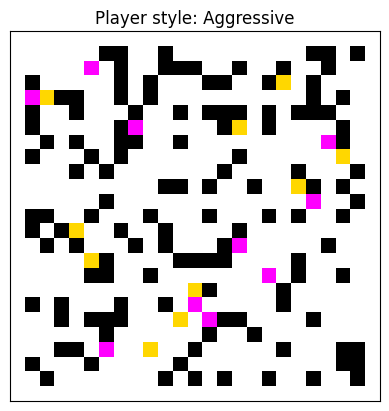

In [ ]:
m = Maze(25, 0.3, 10, 10, 'LHS')
m.coin_pos = coin
m.enemy_pos = enemy

for w in m.wall_pos:
  i, j = w[0], w[1]
  m.maze[i][j] = 1

for c in m.coin_pos:
        if c not in m.enemy_pos:
            i, j = c[0], c[1]
            m.maze[i][j] = 2

for e in m.enemy_pos:
        if e not in m.coin_pos:
            i, j = e[0], e[1]
            m.maze[i][j] = 3
cmap0 = colors.ListedColormap(['white', 'black', 'gold', 'magenta'])
plt.imshow(m.maze, cmap=cmap0)
plt.title('Player style: Aggressive')
plt.xticks([])
plt.yticks([])